In [45]:
def parse_pidstat(data: str):
    rows = data.split("\n")
    output_data = []
    for row in rows[1:]:
        row = row.strip()
        if len(row) == 0:
            continue
        if "UID" in row:
            continue
        parsed = row.split(" ")
        parsed = list(filter(lambda x: len(x) > 0, parsed))
        datum = {
            'timestamp': int(parsed[0]),
            'pid': int(parsed[2]),
            'cpu':float(parsed[7]),
            'command': parsed[-1]
        }
        output_data.append(datum)
    return output_data

In [118]:
import json
from dateutil.parser import isoparse

def parse_iostat(data:str):
    data = json.loads(data)
    data = data['statistics']
    output_data = []
    for datum in data:
        for disk in datum['disk']:
            if disk['disk_device'] != 'nvme0n1':
                continue
        t = {
            'timestamp': int(isoparse(datum['timestamp']).timestamp()),
            'disk': float(disk['kB_wrtn/s'])
        }
        output_data.append(t)
    return output_data        

In [119]:
def read_report_pidstat(report_id):
    with open(f'reports/{report_id}/both/report-pidstat.log', 'r', encoding='utf-8') as f:
        data = f.read()
        return parse_pidstat(data)
    
def read_report_iostat(report_id):
    with open(f'reports/{report_id}/fileio/report-iostat.log', 'r', encoding='utf-8') as f:
        data = f.read()
        return parse_iostat(data)


In [120]:
import os

reports = os.listdir("reports")
reports = sorted(reports)
print(f"{len(reports)} reports detected.")

3 reports detected.


In [121]:
data_old = read_report_pidstat(reports[1])
data_new = read_report_pidstat(reports[2])

data_old_iostat = read_report_iostat(reports[1])
data_new_iostat = read_report_iostat(reports[2])

In [127]:
def get_io(data):
    xs = []
    ys = []
    for datum in data:
        xs.append(datum['timestamp'])
        ys.append(datum['disk'])
    return xs, ys

In [128]:
def get_process_rate(data, process_name):
    groupby = {}
    for datum in data:
        key = datum['timestamp']
        if key not in groupby:
            groupby[key] = 0
        if process_name not in datum['command']:
            continue
        groupby[key] += datum['cpu']
    keys = []
    data = []
    for key in sorted(groupby.keys()):
        keys.append(key)
        data.append(groupby[key]/1600)
    return keys, data

In [129]:
data_old_stress = get_process_rate(data_old,'stress')
data_old_others = get_process_rate(data_old,'s1-agent')
data_new_stress = get_process_rate(data_new,'stress')
data_new_others = get_process_rate(data_new,'s1-agent')
data_old_io = get_io(data_old_iostat)
data_new_io = get_io(data_new_iostat)

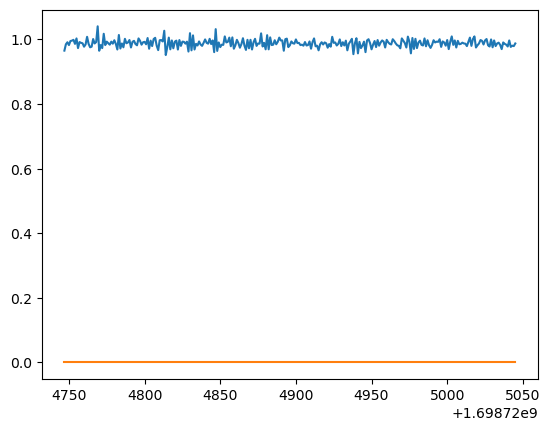

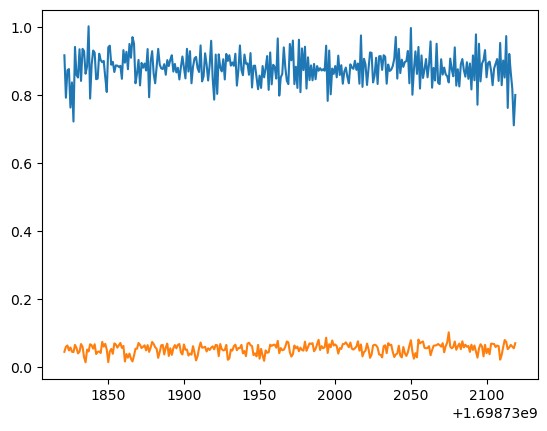

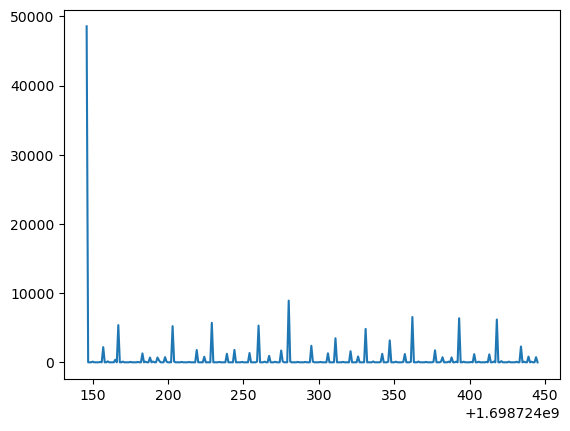

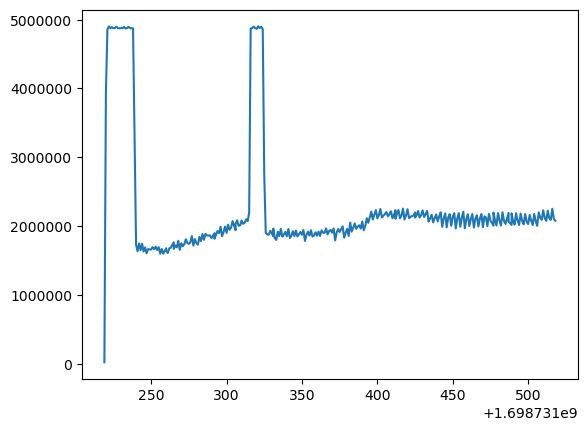

In [132]:
from matplotlib import pyplot as plt

plt.plot(data_old_stress[0],data_old_stress[1])
plt.plot(data_old_others[0],data_old_others[1])
plt.show()

plt.plot(data_new_stress[0],data_new_stress[1])
plt.plot(data_new_others[0],data_new_others[1])
plt.show()

plt.plot(data_old_io[0], data_old_io[1])
plt.show()

plt.plot(data_new_io[0], data_new_io[1])
plt.show()